<a href="https://colab.research.google.com/github/basagliuz/Tirocinio/blob/main/Challenge_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 3
- Use the data file "challenge3.gwf" with channel "H1:CHALLENGE3".
- These are real LIGO data from O2, though we've adjusted the time labels and added some simulated signals.
- The data contain a loud simulated signal with m1 = m2 = 10 solar masses.


## Setup
Run this code, and then 'restart runtime', and run it again.

In [1]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf

# -- for gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge3.gwf', channel = "H1:CHALLENGE3")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')

--2024-09-03 16:48:03--  https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256814830 (245M)
Saving to: ‘challenge3.gwf.4’

challenge3.gwf.4    100%[===================>] 244.92M  53.1MB/s    in 4.9s    

2024-09-03 16:48:08 (49.7 MB/s) - ‘challenge3.gwf.4’ saved [256814830/256814830]



/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## First look at the data

Text(0, 0.5, 'Strain')

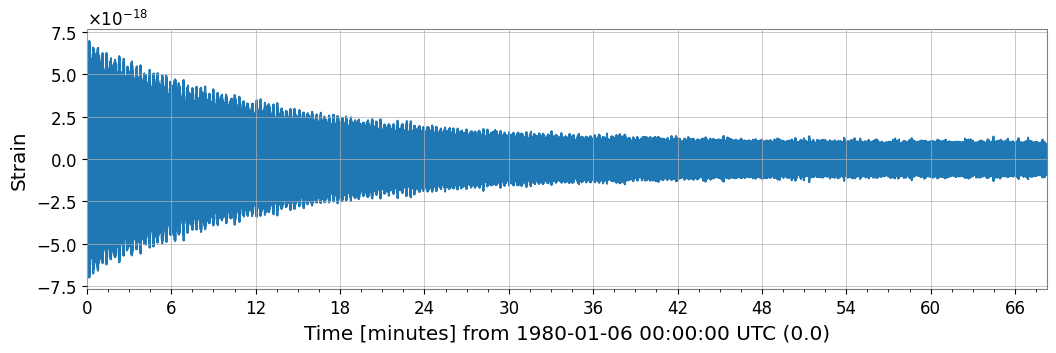

In [2]:
# We start by plotting data in time domain
plot = gwpy_strain.plot()
ax = plot.gca()
ax.set_ylabel('Strain')

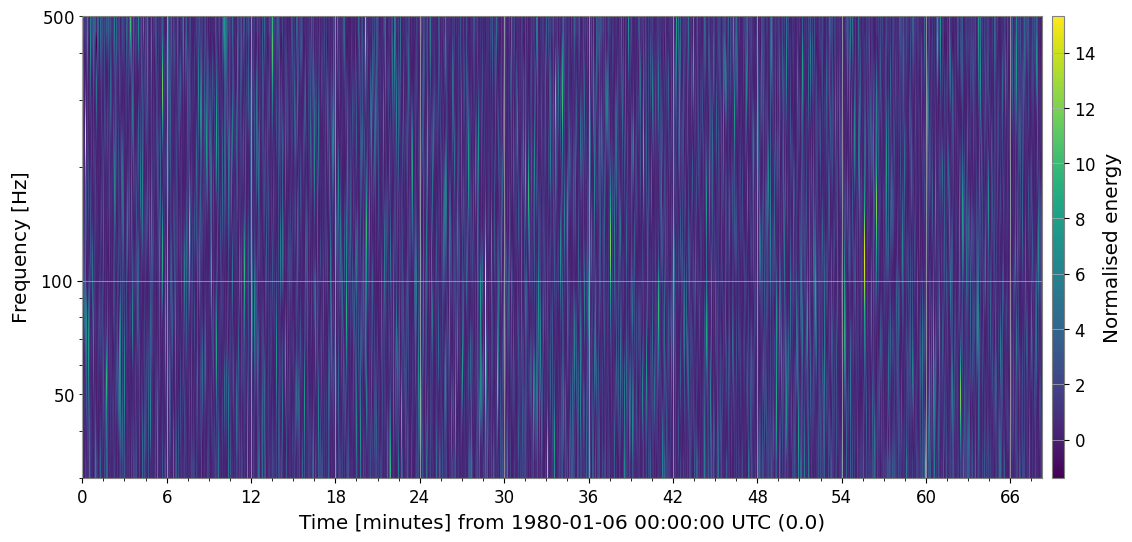

In [3]:
# We proceed to plot a spectrogram of the data
spectrogram = gwpy_strain.q_transform(frange = (30, 500))
plot = spectrogram.plot()
ax = plot.gca()
ax.set_ylim(30, 500)
ax.set_yscale("log")
ax.colorbar(label = "Normalised energy")

## Preconditioning data for SNR

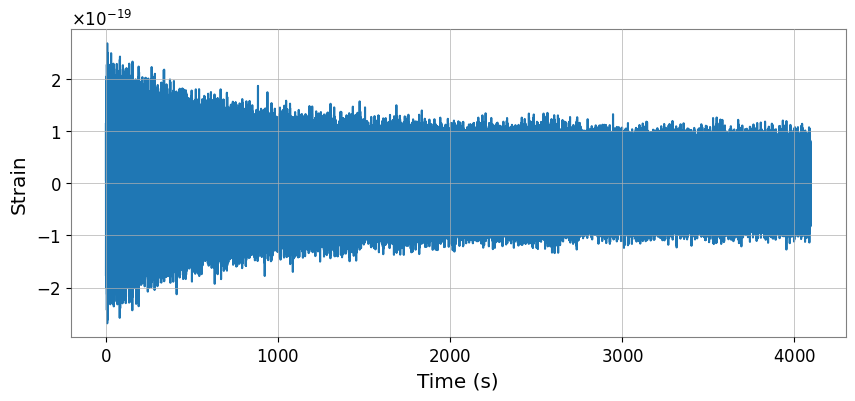

In [4]:
import matplotlib.pyplot as plt
from pycbc.filter import highpass

# Removing low frequency noise
cond_strain = highpass(pycbc_strain, 15)
cond_strain = cond_strain.crop(2, 2)
plt.figure(figsize=[10, 4])
plt.plot(cond_strain.sample_times, cond_strain)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

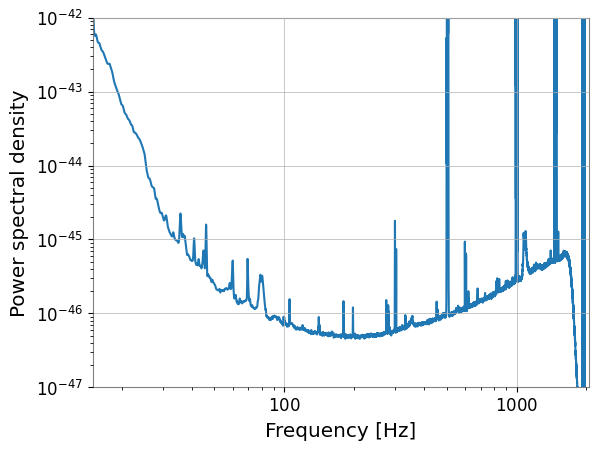

In [5]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

fn = cond_strain.sample_rate / 2

# Estimating and plotting the power spectral density
psd = cond_strain.psd(4)
psd = interpolate(psd, cond_strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * cond_strain.sample_rate), low_frequency_cutoff = 15)
plt.loglog(psd.sample_frequencies, psd)
plt.xlim(15, fn)
plt.ylim(1e-47, 1e-42)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density')
plt.show()

In [6]:
from pycbc.waveform import get_td_waveform

# Simulating the suggested waveform
m = 10 # Solar masses
model, _ = get_td_waveform(approximant = "SEOBNRv4_opt",
                     mass1 = m,
                     mass2 = m,
                     delta_t = cond_strain.delta_t,
                     f_lower = 20)

# Resizing and shifting the model to match our data
model.resize(len(cond_strain))
model = model.cyclic_time_shift(model.start_time)

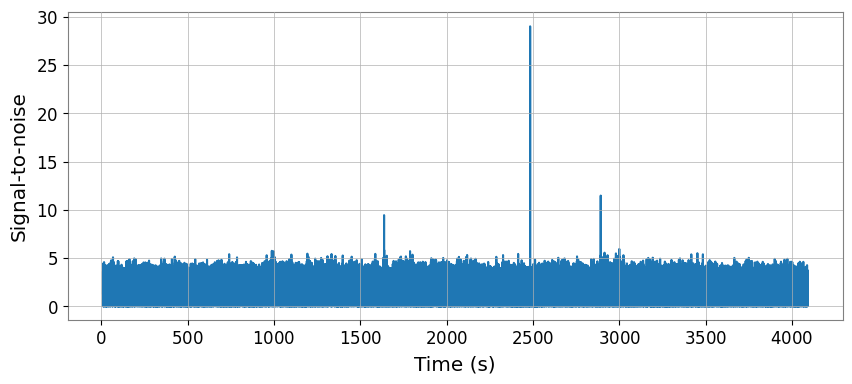

In [7]:
from pycbc.filter import matched_filter
import numpy as np

# Evalueating SNR
snr = matched_filter(model, cond_strain, psd = psd, low_frequency_cutoff = 20)
snr = snr.crop(4 + 4, 4)

# Plotting SNR
plt.figure(figsize = [10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

## Questions
1. What is the merger time of this signal?
2. What is the matched-filter SNR of this signal?



In [9]:
# Finding peak position and corresponding SNR in SNR time series
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

We found a signal at 2483.967529296875s with SNR 29.01136183658599
